# NESTML STDP windows tutorial

In this tutorial, we will plot the "window function", relating the weight change of a synapse to the relative timing of a single pair of pre- and postsynaptic spikes. This type of synaptic plasticity is commonly known as spike-timing depdendent plasticity (STDP).

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import nest
import numpy as np
import os
import re
from pynestml.frontend.pynestml_frontend import to_nest, install_nest

NEST_SIMULATOR_INSTALL_LOCATION = nest.ll_api.sli_func("statusdict/prefix ::")

## Preliminaries

Experiments have shown that synaptic strength changes as a function of the precise spike timing of the presynaptic and postsynaptic neurons. If the pre neuron fires an action potential strictly before the post neuron, the synapse connecting them will be strengthened (“facilitated”). If the pre neuron fires after the post neuron, the synapse will be weakened (“depressed”). The depression and facilitation effects become stronger when the spikes occurred closer together in time. This is illustrated by empirical results (open circles), fitted by exponential curves (solid lines).

<!--
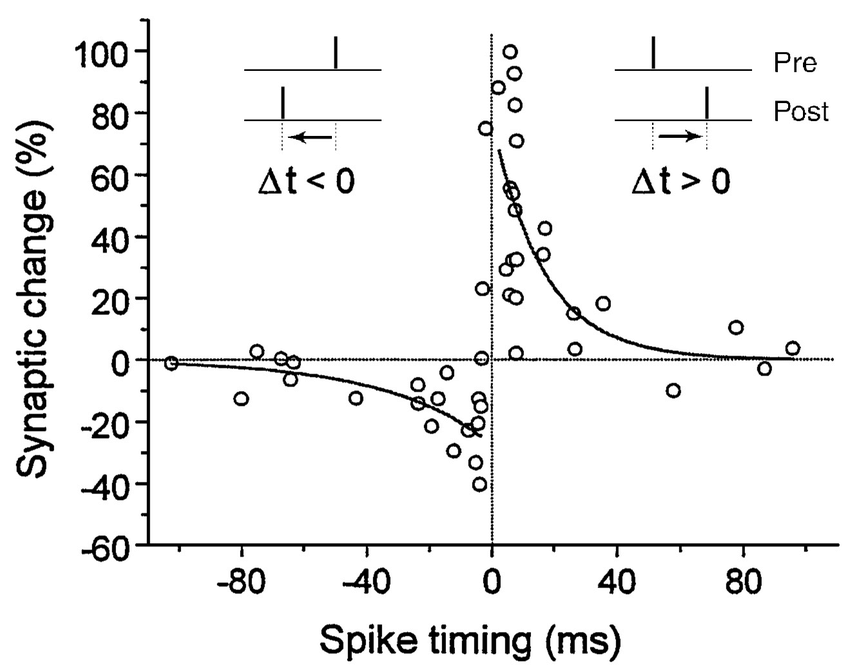
-->
<div>
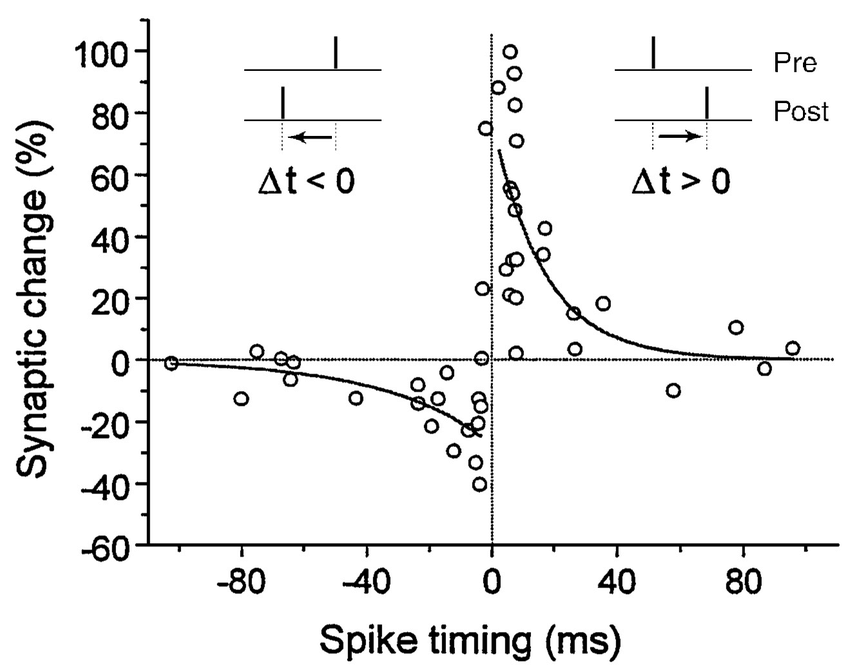
</div>

*Asymmetric STDP learning window. Spike-timing window of STDP for the induction of synaptic potentiation and depression characterized in hippocampal cultures. Data points from Bi and Poo (1998) [18], represent the relative change in the amplitude of EPSC after repetitive correlated activity of pre-post spike pairs. The LTP (+) and LTD (-) windows are fitted by the exponential function ∆g = A ± exp(−|∆t|/τ), with parameters A + = 0.86, A − = −0.25, τ + = 19 ms, and τ − = 34 ms. Adopted from Bi and Wang (2002).*

We will define the theoretical model following [3]_.

A pair of spikes in the input and the output cell, at times $t_i$ and $t_j$ respectively, induces a change $\Delta w$ in the weight $w$:

\begin{equation}
\Delta^\pm w = \pm \lambda \cdot f_\pm(w) \cdot K(|t_o - t_i|)
\end{equation}

The weight is increased by $\Delta^+ w$ when $t_o>t_i$ and decreased by $\Delta^- w$ when $t_i>t_o$. The temporal dependence of the update is defined by the filter kernel $K$ which is taken to be $K(t) = \exp(-t/\tau)$. The coefficient $\lambda\in\mathbb{R}$ sets the magnitude of the update. The functions $f_\pm(w)$ determine the relative magnitude of the changes in the positive and negative direction. These are here taken as

\begin{align}
f_+(w) &= (1 - w)^{\mu_+}\\
f_-(w) &= \alpha w^{\mu_-}
\end{align}

with the parameter $\alpha\in\mathbb{R}, \alpha>0$ allowing to set an asymmetry between increasing and decreasing the synaptic efficacy, and $\mu_\pm\in\{0,1\}$ allowing to choose between four different kinds of STDP (for references, see https://nest-simulator.readthedocs.io/en/nest-2.20.1/models/stdp.html?highlight=stdp#_CPPv4I0EN4nest14STDPConnectionE).

To implement the kernel, we use two extra state variables to keep track of recent spiking activity. These could correspond to calcium concentration in biology. One presynaptic trace value and another postsynaptic trace value is used, for pre- and post spiking, respectively. These maintain a history of neuron spikes, being incremented by 1 whenever a spike is generated, and decaying back to zero exponentially; in other words, a convolution between the exponentially decaying kernel and the emitted spike train:

\begin{equation}
\text{tr_pre} = K \ast \sum_i \delta_{pre,i}
\end{equation}

and

\begin{equation}
\text{tr_post} = K \ast \sum_i \delta_{post,i}
\end{equation}

These are implemented in the NESTML model as follows:

```
  equations:
    # all-to-all trace of presynaptic neuron
    kernel pre_tr_kernel = exp(-t / tau_tr_pre)
    inline pre_tr real = convolve(pre_tr_kernel, pre_spikes)

    # all-to-all trace of postsynaptic neuron
    kernel post_tr_kernel = exp(-t / tau_tr_post)
    inline post_tr real = convolve(post_tr_kernel, post_spikes)
end
```

with time constants defined as parameters:

```
   parameters:
     tau_tr_pre ms = 20 ms
     tau_tr_post ms = 20 ms
   end
```

With the traces in place, the weight updates can then be expressed closely following the mathematical definitions.

Begin by defining the weight and its initial value:

```
   state:
     w real = 1.
   end
```

The update rule for facilitation:

\begin{equation}
\Delta^+ w = \lambda \cdot (1 - w)^{\mu+} \cdot \text{pre_trace}
\end{equation}

In NESTML, this rule is written in the `onReceive` event handler block. Statements in this block will be executed when the event occurs: in this case, receiving a presynaptic spike. In NESTML, additional scaling with an absolute maximum weight ``Wmax`` is added.

```
   onReceive(post_spikes):
     # potentiate synapse
     w_ real = Wmax * ( w / Wmax  + (lambda * ( 1. - ( w / Wmax ) )**mu_plus * pre_trace ))
     w = min(Wmax, w_)
   end
```

The update rule for depression :

\begin{equation}
\Delta^- w = -\alpha \cdot \lambda \cdot w^{\mu_-} \cdot \text{post_trace}
\end{equation}

```
   onReceive(pre_spikes):
     # depress synapse
     w_ real = Wmax * ( w / Wmax  - ( alpha * lambda * ( w / Wmax )**mu_minus * post_trace ))
     w = max(Wmin, w_)

     # deliver spike to postsynaptic partner
     deliver_spike(w, d)
   end
```

Finally, the remaining parameters are defined:

```
   parameters:
     lambda real = .01
     alpha real = 1.
     mu_plus real = 1.
     mu_minus real = 1.
     Wmax real = 100.
     Wmin real = 0.
   end
```


## Generating code with NESTML

### Formulating the model in NESTML

To generate fast code, NESTML needs to process the synapse model together with the neuron model that will be its postsynaptic partner in the network instantiantion.

In this tutorial, we will use a very simple integrate-and-fire model, where arriving spikes cause an instantaneous increment of the membrane potential. Let's download the model from the NESTML repository so it becomes available locally:

In [2]:
import urllib.request 
if not os.path.isdir("models"):
    os.makedirs("models")
urllib.request.urlretrieve("https://raw.githubusercontent.com/nest/nestml/master/models/iaf_psc_delta.nestml",
                           "models/iaf_psc_delta.nestml")

('models/iaf_psc_delta.nestml', <http.client.HTTPMessage at 0x7f6c00314880>)

We now define a helper function to generate the C++ code for the models, build it as a NEST extension module, and load the module into the kernel. The resulting model names are composed of associated neuron and synapse partners, because of the co-generation, for example, "stdp_synapse__with_iaf_psc_delta" and "iaf_psc_delta__with_stdp_synapse".

Because NEST does not support un- or reloading of modules at the time of writing, we implement a workaround that appends a unique number to the name of each generated model, for example, "stdp_synapse0__with_iaf_psc_delta0" and "iaf_psc_delta0__with_stdp_synapse0".

The resulting neuron and synapse model names are returned by the function, so we do not have to think about these internals.

In [3]:
n_modules_generated = 0
def generate_code_for(nestml_synapse_model: str):
    """Generate code for a given synapse model, passed as a string, in combination with
    the iaf_psc_delta model.
    
    NEST cannot yet reload modules. Workaround using counter to generate unique names."""
    global n_modules_generated
   
    # append digit to the neuron model name and neuron model filename
    with open("models/iaf_psc_delta.nestml", "r") as nestml_model_file_orig:
        nestml_neuron_model = nestml_model_file_orig.read()
        nestml_neuron_model = re.sub("neuron\ [^:\s]*:",
                                     "neuron iaf_psc_delta" + str(n_modules_generated) + ":", nestml_neuron_model)
        with open("models/iaf_psc_delta" + str(n_modules_generated) + ".nestml", "w") as nestml_model_file_mod:
            print(nestml_neuron_model, file=nestml_model_file_mod)

    # append digit to the synapse model name and synapse model filename
    nestml_synapse_model_name = re.findall("synapse\ [^:\s]*:", nestml_synapse_model)[0][8:-1]
    nestml_synapse_model = re.sub("synapse\ [^:\s]*:",
                                  "synapse " + nestml_synapse_model_name + str(n_modules_generated) + ":", nestml_synapse_model)
    with open("models/" + nestml_synapse_model_name + str(n_modules_generated) + ".nestml", "w") as nestml_model_file:
        print(nestml_synapse_model, file=nestml_model_file)

    # generate the code for neuron and synapse (co-generated)
    module_name = "nestml_" + str(n_modules_generated) + "_module"
    to_nest(input_path=["models/iaf_psc_delta" + str(n_modules_generated) + ".nestml",
                        "models/" + nestml_synapse_model_name + str(n_modules_generated) + ".nestml"],
            target_path="/tmp/nestml_module",
            logging_level="INFO",
            module_name=module_name,
            suffix="_nestml",
            codegen_opts={"neuron_parent_class": "StructuralPlasticityNode",
                          "neuron_parent_class_include": "structural_plasticity_node.h",
                          "neuron_synapse_pairs": [{"neuron": "iaf_psc_delta" + str(n_modules_generated),
                                                    "synapse": nestml_synapse_model_name + str(n_modules_generated),
                                                    "post_ports": ["post_spikes"]}]})
    install_nest("/tmp/nestml_module", NEST_SIMULATOR_INSTALL_LOCATION)
    
    # load module into NEST
    nest.ResetKernel()
    nest.Install(module_name)

    mangled_neuron_name = "iaf_psc_delta" + str(n_modules_generated) + "_nestml__with_" + nestml_synapse_model_name + str(n_modules_generated) + "_nestml"
    mangled_synapse_name = nestml_synapse_model_name + str(n_modules_generated) + "_nestml__with_iaf_psc_delta" + str(n_modules_generated) + "_nestml"

    n_modules_generated += 1
    
    return mangled_neuron_name, mangled_synapse_name

We now go on to define the full synapse model in NESTML:

In [4]:
nestml_stdp_model = """
synapse stdp:

  state:
    w real = 1.
  end

  parameters:
    d ms = 1 ms  @nest::delay   # !!! cannot have a variable called "delay"
    lambda real = .01
    tau_tr_pre ms = 20 ms
    tau_tr_post ms = 20 ms
    alpha real = 1
    mu_plus real = 1
    mu_minus real = 1
    Wmax real = 100.
    Wmin real = 0.
  end

  equations:
    kernel pre_trace_kernel = exp(-t / tau_tr_pre)
    inline pre_trace real = convolve(pre_trace_kernel, pre_spikes)

    # all-to-all trace of postsynaptic neuron
    kernel post_trace_kernel = exp(-t / tau_tr_post)
    inline post_trace real = convolve(post_trace_kernel, post_spikes)
  end

  input:
    pre_spikes nS <- spike
    post_spikes nS <- spike
  end

  output: spike

  postReceive:
    # potentiate synapse
    w_ real = Wmax * ( w / Wmax  + (lambda * ( 1. - ( w / Wmax ) )**mu_plus * pre_trace ))
    w = min(Wmax, w_)
  end

  preReceive:
    # depress synapse
    w_ real = Wmax * ( w / Wmax  - ( alpha * lambda * ( w / Wmax )**mu_minus * post_trace ))
    w = max(Wmin, w_)

    # deliver spike to postsynaptic partner
    deliver_spike(w, d)
  end
end
"""

Generate the code, build the user module and make the model available to instantiate in NEST:

In [5]:
neuron_model_name, synapse_model_name = generate_code_for(nestml_stdp_model)

[1,GLOBAL, INFO]: List of files that will be processed:
[2,GLOBAL, INFO]: /home/charl/julich/nestml-fork-jit-third-factor/nestml/doc/tutorials/stdp_windows/models/iaf_psc_delta0.nestml
[3,GLOBAL, INFO]: /home/charl/julich/nestml-fork-jit-third-factor/nestml/doc/tutorials/stdp_windows/models/stdp0.nestml
[4,GLOBAL, INFO]: Start processing '/home/charl/julich/nestml-fork-jit-third-factor/nestml/doc/tutorials/stdp_windows/models/iaf_psc_delta0.nestml'!
ANTLR runtime and generated code versions disagree: 4.9.2!=4.7.1
ANTLR runtime and generated code versions disagree: 4.9.2!=4.7.1
[5,iaf_psc_delta0_nestml, INFO, [58:0;131:0]]: Start building symbol table!
[6,iaf_psc_delta0_nestml, WARNING, [67:4;67:22]]: Variable 'G' has the same name as a physical unit!
[7,iaf_psc_delta0_nestml, WARNING, [88:4;88:22]]: Variable 'h' has the same name as a physical unit!
[8,iaf_psc_delta0_nestml, WARNING, [69:70;69:70]]: Non-matching unit types at pA +/- pA buffer! Implicitly replaced by pA +/- 1.0 * pA buf

INFO:ode-toolbox: analysing input:
INFO:{
    "dynamics": [
        {
            "expression": "V_abs' = -V_abs / tau_m + (1.0 / 1.0 / 1.0) * 0 + (I_e + I_stim) / C_m",
            "initial_values": {
                "V_abs": "0"
            }
        },
        {
            "expression": "post_trace_kernel__for_stdp0_nestml__X__post_spikes__for_stdp0_nestml = exp(-t / tau_tr_post__for_stdp0_nestml)",
            "initial_values": {}
        }
    ],
    "options": {
        "output_timestep_symbol": "__h"
    },
    "parameters": {
        "C_m": "250",
        "E_L": "-70",
        "I_e": "0",
        "Theta": "-55 - E_L",
        "V_min": "-inf * 1",
        "V_reset": "-70 - E_L",
        "t_ref": "2",
        "tau_m": "10",
        "tau_syn": "2",
        "tau_tr_post__for_stdp0_nestml": "20",
        "with_refr_input": "false"
    }
}
INFO:Processing global options...
INFO:Processing input shapes...
INFO:
Processing shape V_abs with defining expression = "-V_abs / tau_m + (1.0 

[25,stdp0_nestml__with_iaf_psc_delta0_nestml, INFO, [13:17;13:17]]: Implicit casting from (compatible) type 'integer' to 'real'.
[26,stdp0_nestml__with_iaf_psc_delta0_nestml, INFO, [14:19;14:19]]: Implicit casting from (compatible) type 'integer' to 'real'.
[27,stdp0_nestml__with_iaf_psc_delta0_nestml, INFO, [15:20;15:20]]: Implicit casting from (compatible) type 'integer' to 'real'.
Successfully constructed neuron-synapse pair models
[28,GLOBAL, INFO]: Analysing/transforming neuron 'iaf_psc_delta0_nestml__with_stdp0_nestml'
[29,iaf_psc_delta0_nestml__with_stdp0_nestml, INFO, [58:0;131:0]]: Starts processing of the model 'iaf_psc_delta0_nestml__with_stdp0_nestml'
ANTLR runtime and generated code versions disagree: 4.9.2!=4.7.1
ANTLR runtime and generated code versions disagree: 4.9.2!=4.7.1
ANTLR runtime and generated code versions disagree: 4.9.2!=4.7.1
ANTLR runtime and generated code versions disagree: 4.9.2!=4.7.1
ANTLR runtime and generated code versions disagree: 4.9.2!=4.7.1
ANT

INFO:
Processing shape post_trace_kernel__for_stdp0_nestml__X__post_spikes__for_stdp0_nestml with defining expression = "exp(-t/tau_tr_post__for_stdp0_nestml)"
INFO:
Processing shape V_abs with defining expression = "-V_abs / tau_m + (1.0 / 1.0 / 1.0) * 0 + (I_e + I_stim) / C_m"
INFO:
Processing shape post_trace_kernel__for_stdp0_nestml__X__post_spikes__for_stdp0_nestml with defining expression = "exp(-t/tau_tr_post__for_stdp0_nestml)"
INFO:Shape V_abs: reconstituting expression -V_abs/tau_m + (I_e + I_stim)/C_m
INFO:Shape post_trace_kernel__for_stdp0_nestml__X__post_spikes__for_stdp0_nestml: reconstituting expression -post_trace_kernel__for_stdp0_nestml__X__post_spikes__for_stdp0_nestml/tau_tr_post__for_stdp0_nestml
INFO:Dependency analysis...
INFO:Generating propagators for the following symbols: post_trace_kernel__for_stdp0_nestml__X__post_spikes__for_stdp0_nestml
INFO:Generating numerical solver for the following symbols: V_abs
INFO:In ode-toolbox: returning outdict = 
INFO:[
    {

ANTLR runtime and generated code versions disagree: 4.9.2!=4.7.1
ANTLR runtime and generated code versions disagree: 4.9.2!=4.7.1
ANTLR runtime and generated code versions disagree: 4.9.2!=4.7.1
ANTLR runtime and generated code versions disagree: 4.9.2!=4.7.1
ANTLR runtime and generated code versions disagree: 4.9.2!=4.7.1
ANTLR runtime and generated code versions disagree: 4.9.2!=4.7.1
ANTLR runtime and generated code versions disagree: 4.9.2!=4.7.1
ANTLR runtime and generated code versions disagree: 4.9.2!=4.7.1
ANTLR runtime and generated code versions disagree: 4.9.2!=4.7.1
ANTLR runtime and generated code versions disagree: 4.9.2!=4.7.1
ANTLR runtime and generated code versions disagree: 4.9.2!=4.7.1
ANTLR runtime and generated code versions disagree: 4.9.2!=4.7.1
[31,iaf_psc_delta0_nestml__with_stdp0_nestml, INFO, [58:0;131:0]]: Start building symbol table!
[32,iaf_psc_delta0_nestml__with_stdp0_nestml, WARNING, [88:4;88:22]]: Variable 'h' has the same name as a physical unit!


INFO:ode-toolbox: analysing input:
INFO:{
    "dynamics": [
        {
            "expression": "pre_trace_kernel__X__pre_spikes = exp(-t / tau_tr_pre)",
            "initial_values": {}
        }
    ],
    "options": {
        "output_timestep_symbol": "__h"
    },
    "parameters": {
        "Wmax": "1.000000E+02",
        "Wmin": "0.000000E+00",
        "alpha": "1",
        "d": "1",
        "lambda": "1.000000E-02",
        "mu_minus": "1",
        "mu_plus": "1",
        "tau_tr_pre": "20"
    }
}
INFO:Processing global options...
INFO:Processing input shapes...
INFO:
Processing shape pre_trace_kernel__X__pre_spikes with defining expression = "exp(-t/tau_tr_pre)"
INFO:
Processing shape pre_trace_kernel__X__pre_spikes with defining expression = "exp(-t/tau_tr_pre)"
INFO:Shape pre_trace_kernel__X__pre_spikes: reconstituting expression -pre_trace_kernel__X__pre_spikes/tau_tr_pre
INFO:Dependency analysis...
INFO:Generating propagators for the following symbols: pre_trace_kernel__X__

ANTLR runtime and generated code versions disagree: 4.9.2!=4.7.1
ANTLR runtime and generated code versions disagree: 4.9.2!=4.7.1
failure resolving symbol: post_spikes__for_stdp0_nestml
ANTLR runtime and generated code versions disagree: 4.9.2!=4.7.1
ANTLR runtime and generated code versions disagree: 4.9.2!=4.7.1
ANTLR runtime and generated code versions disagree: 4.9.2!=4.7.1
ANTLR runtime and generated code versions disagree: 4.9.2!=4.7.1
Analysing/transforming synapse stdp0_nestml__with_iaf_psc_delta0_nestml.
[33,stdp0_nestml__with_iaf_psc_delta0_nestml, INFO, [2:0;50:0]]: Starts processing of the model 'stdp0_nestml__with_iaf_psc_delta0_nestml'
ANTLR runtime and generated code versions disagree: 4.9.2!=4.7.1
ANTLR runtime and generated code versions disagree: 4.9.2!=4.7.1
[34,stdp0_nestml__with_iaf_psc_delta0_nestml, INFO, [2:0;50:0]]: The neuron 'stdp0_nestml__with_iaf_psc_delta0_nestml' will be analysed!
ANTLR runtime and generated code versions disagree: 4.9.2!=4.7.1
ANTLR runt

### Running the simulation in NEST

Let's define a function that will instantiate a simple network with one presynaptic cell and one postsynaptic cell connected by a single synapse, then run a simulation and plot the results.

In [6]:
def run_network(pre_spike_time, post_spike_time,
                          neuron_model_name,
                          synapse_model_name,
                          resolution=1., # [ms]
                          delay=1., # [ms]
                          lmbda=1E-6,
                          sim_time=None,  # if None, computed from pre and post spike times
                          synapse_parameters=None,  # optional dictionary passed to the synapse
                          fname_snip=""):

    #nest.set_verbosity("M_WARNING")
    nest.set_verbosity("M_ALL")

    nest.ResetKernel()
    nest.SetKernelStatus({'resolution': resolution})

    wr = nest.Create('weight_recorder')
    nest.CopyModel(synapse_model_name, "stdp_nestml_rec",
                {"weight_recorder": wr[0],
                 "w": 1.,
                 "delay": delay,
                 "d": delay,
                 "receptor_type": 0,
                 "mu_minus": 0.,
                 "mu_plus": 0.})

    # create spike_generators with these times
    pre_sg = nest.Create("spike_generator",
                         params={"spike_times": [pre_spike_time, sim_time - 10.]})
    post_sg = nest.Create("spike_generator",
                          params={"spike_times": [post_spike_time],
                                  'allow_offgrid_times': True})

    # create parrot neurons and connect spike_generators
    pre_neuron = nest.Create("parrot_neuron")
    post_neuron = nest.Create(neuron_model_name)

    spikedet_pre = nest.Create("spike_recorder")
    spikedet_post = nest.Create("spike_recorder")
    #mm = nest.Create("multimeter", params={"record_from" : ["V_m"]})

    nest.Connect(pre_sg, pre_neuron, "one_to_one", syn_spec={"delay": 1.})
    nest.Connect(post_sg, post_neuron, "one_to_one", syn_spec={"delay": 1., "weight": 9999.})
    nest.Connect(pre_neuron, post_neuron, "all_to_all", syn_spec={'synapse_model': 'stdp_nestml_rec'})
    #nest.Connect(mm, post_neuron)

    nest.Connect(pre_neuron, spikedet_pre)
    nest.Connect(post_neuron, spikedet_post)

    # get STDP synapse and weight before protocol
    syn = nest.GetConnections(source=pre_neuron, synapse_model="stdp_nestml_rec")
    if synapse_parameters is None:
        synapse_parameters = {}
    synapse_parameters.update({"lambda": lmbda})
    nest.SetStatus(syn, synapse_parameters)

    initial_weight = nest.GetStatus(syn)[0]["w"]
    np.testing.assert_allclose(initial_weight, 1)
    nest.Simulate(sim_time)
    updated_weight = nest.GetStatus(syn)[0]["w"]

    actual_t_pre_sp = nest.GetStatus(spikedet_pre)[0]["events"]["times"][0]
    actual_t_post_sp = nest.GetStatus(spikedet_post)[0]["events"]["times"][0]

    dt = actual_t_post_sp - actual_t_pre_sp
    dw = (updated_weight - initial_weight) / lmbda

    return dt, dw

Then, we can run the experiment. We set the pre spike time to a constant (100 ms) and loop over values for the post spike time (25 to 175 ms).

Note that the dendritic delay in this example has been set to 10 ms, to make its effect on the STDP window more clear: it is not centered around zero, but shifted to the left by the dendritic delay. Hint: play with the parameters a bit here and see the effects it has on the returned window.

In [7]:
def stdp_window(neuron_model_name, synapse_model_name, synapse_parameters=None):
    sim_time = 1000.  # [ms]
    pre_spike_time = 100. #sim_time / 2  # [ms]
    delay = 10. # dendritic delay [ms]

    dt_vec = []
    dw_vec = []
    for post_spike_time in np.arange(25, 175).astype(float):
        dt, dw = run_network(pre_spike_time, post_spike_time,
                          neuron_model_name,
                          synapse_model_name,
                          resolution=1., # [ms]
                          delay=delay, # [ms]
                          synapse_parameters=synapse_parameters,
                          sim_time=sim_time)
        dt_vec.append(dt)
        dw_vec.append(dw)
        
    return dt_vec, dw_vec, delay

In [8]:
def plot_stdp_window(dt_vec, dw_vec, delay):
    fig, ax = plt.subplots(dpi=120)
    ax.scatter(dt_vec, dw_vec)
    ax.set_xlabel(r"t_post - t_pre [ms]")
    ax.set_ylabel(r"$\Delta w$")

    for _ax in [ax]:
        _ax.grid(which="major", axis="both")
        _ax.grid(which="minor", axis="x", linestyle=":", alpha=.4)
        _ax.set_xlim(np.amin(dt_vec), np.amax(dt_vec))
        #_ax.minorticks_on()
        #_ax.set_xlim(0., sim_time)

    ylim = ax.get_ylim()
    ax.plot((np.amin(dt_vec), np.amax(dt_vec)), (0, 0), linestyle="--", color="black", linewidth=2, alpha=.5)
    ax.plot((-delay, -delay), ylim, linestyle="--", color="black", linewidth=2, alpha=.5)
    ax.set_ylim(ylim)

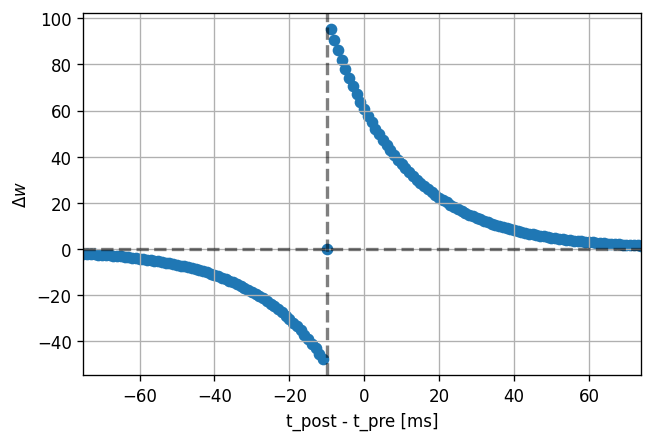

In [10]:
dt_vec, dw_vec, delay = stdp_window(neuron_model_name, synapse_model_name,
                                    synapse_parameters={"alpha": .5})

plot_stdp_window(dt_vec, dw_vec, delay)

Symmetric LTP or LTD-only
----------------------

Depending on the frequency at which the spike pairing protocol is repeated, a symmetric potentiation-only window can occur for high repetition rates, whereas for low rates, a depression-only window is observed.

Facilitation-only is easy to obtain without even changing the model:

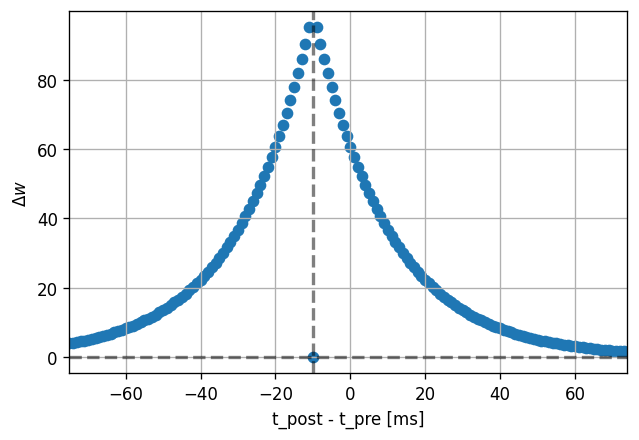

In [11]:
dt_vec, dw_vec, delay = stdp_window(neuron_model_name, synapse_model_name,
                                    synapse_parameters={"alpha": -1.})
plot_stdp_window(dt_vec, dw_vec, delay)

Adapt the model to obtain the symmetric depression-only window.

Windowed STDP
------------

In this variant of the original STDP rule, we allow only spikes more than a few milliseconds apart to cause the weight to change. If the pre-post absolute $|\Delta t|$ is smaller than some threshold, the weight change should be zero.

In [12]:
nestml_windowed_stdp_model = """
synapse stdp_windowed:

  state:
    w real = 1.
    pre_nn_trace real = 0.
    post_nn_trace real = 0.
  end

  parameters:
    d ms = 1 ms  @nest::delay   # !!! cannot have a variable called "delay"
    lambda real = .01
    tau_tr_pre ms = 20 ms
    tau_tr_post ms = 20 ms
    alpha real = 1
    mu_plus real = 1
    mu_minus real = 1
    Wmax real = 100.
    Wmin real = 0.
    tau_recency_window_pre ms = 10 ms
    tau_recency_window_post ms = 10 ms
  end

  equations:
    kernel pre_trace_kernel = exp(-t / tau_tr_pre)
    inline pre_trace real = convolve(pre_trace_kernel, pre_spikes)

    # all-to-all trace of postsynaptic neuron
    kernel post_trace_kernel = exp(-t / tau_tr_post)
    inline post_trace real = convolve(post_trace_kernel, post_spikes)

    pre_nn_trace' = -pre_nn_trace / tau_recency_window_pre
    post_nn_trace' = -post_nn_trace / tau_recency_window_post
  end

  input:
    pre_spikes nS <- spike
    post_spikes nS <- spike
  end

  output: spike

  postReceive:
    post_nn_trace = 1

    if pre_nn_trace < .7:
      # potentiate synapse
      w_ real = Wmax * ( w / Wmax  + (lambda * ( 1. - ( w / Wmax ) )**mu_plus * pre_trace ))
      w = min(Wmax, w_)
    end
  end

  preReceive:
    pre_nn_trace = 1

    if post_nn_trace < .7:
      # depress synapse
      w_ real = Wmax * ( w / Wmax  - ( alpha * lambda * ( w / Wmax )**mu_minus * post_trace ))
      w = max(Wmin, w_)
    end

    # deliver spike to postsynaptic partner
    deliver_spike(w, d)
  end
end
"""

In [15]:
neuron_model_name, synapse_model_name = generate_code_for(nestml_windowed_stdp_model)

[1,GLOBAL, INFO]: List of files that will be processed:
[2,GLOBAL, INFO]: /home/charl/julich/nestml-fork-jit-third-factor/nestml/doc/tutorials/stdp_windows/models/iaf_psc_delta2.nestml
[3,GLOBAL, INFO]: /home/charl/julich/nestml-fork-jit-third-factor/nestml/doc/tutorials/stdp_windows/models/stdp_windowed2.nestml
[4,GLOBAL, INFO]: Start processing '/home/charl/julich/nestml-fork-jit-third-factor/nestml/doc/tutorials/stdp_windows/models/iaf_psc_delta2.nestml'!
ANTLR runtime and generated code versions disagree: 4.9.2!=4.7.1
ANTLR runtime and generated code versions disagree: 4.9.2!=4.7.1
[5,iaf_psc_delta2_nestml, INFO, [58:0;131:0]]: Start building symbol table!
[6,iaf_psc_delta2_nestml, WARNING, [67:4;67:22]]: Variable 'G' has the same name as a physical unit!
[7,iaf_psc_delta2_nestml, WARNING, [88:4;88:22]]: Variable 'h' has the same name as a physical unit!
[8,iaf_psc_delta2_nestml, WARNING, [69:70;69:70]]: Non-matching unit types at pA +/- pA buffer! Implicitly replaced by pA +/- 1.0

INFO:ode-toolbox: analysing input:
INFO:{
    "dynamics": [
        {
            "expression": "V_abs' = -V_abs / tau_m + (1.0 / 1.0 / 1.0) * 0 + (I_e + I_stim) / C_m",
            "initial_values": {
                "V_abs": "0"
            }
        },
        {
            "expression": "post_nn_trace__for_stdp_windowed2_nestml' = -post_nn_trace__for_stdp_windowed2_nestml / tau_recency_window_post__for_stdp_windowed2_nestml",
            "initial_values": {
                "post_nn_trace__for_stdp_windowed2_nestml": "0.000000E+00"
            }
        },
        {
            "expression": "post_trace_kernel__for_stdp_windowed2_nestml__X__post_spikes__for_stdp_windowed2_nestml = exp(-t / tau_tr_post__for_stdp_windowed2_nestml)",
            "initial_values": {}
        }
    ],
    "options": {
        "output_timestep_symbol": "__h"
    },
    "parameters": {
        "C_m": "250",
        "E_L": "-70",
        "I_e": "0",
        "Theta": "-55 - E_L",
        "V_min": "-inf * 1",

[28,stdp_windowed2_nestml__with_iaf_psc_delta2_nestml, INFO, [15:17;15:17]]: Implicit casting from (compatible) type 'integer' to 'real'.
[29,stdp_windowed2_nestml__with_iaf_psc_delta2_nestml, INFO, [16:19;16:19]]: Implicit casting from (compatible) type 'integer' to 'real'.
[30,stdp_windowed2_nestml__with_iaf_psc_delta2_nestml, INFO, [17:20;17:20]]: Implicit casting from (compatible) type 'integer' to 'real'.
[31,stdp_windowed2_nestml__with_iaf_psc_delta2_nestml, INFO, [54:19;54:19]]: Implicit casting from (compatible) type 'integer' to 'real'.
Successfully constructed neuron-synapse pair models
[32,GLOBAL, INFO]: Analysing/transforming neuron 'iaf_psc_delta2_nestml__with_stdp_windowed2_nestml'
[33,iaf_psc_delta2_nestml__with_stdp_windowed2_nestml, INFO, [58:0;131:0]]: Starts processing of the model 'iaf_psc_delta2_nestml__with_stdp_windowed2_nestml'
ANTLR runtime and generated code versions disagree: 4.9.2!=4.7.1
ANTLR runtime and generated code versions disagree: 4.9.2!=4.7.1
ANTLR 

INFO:
Processing shape post_nn_trace__for_stdp_windowed2_nestml with defining expression = "-post_nn_trace__for_stdp_windowed2_nestml / tau_recency_window_post__for_stdp_windowed2_nestml"
INFO:
Processing shape post_trace_kernel__for_stdp_windowed2_nestml__X__post_spikes__for_stdp_windowed2_nestml with defining expression = "exp(-t/tau_tr_post__for_stdp_windowed2_nestml)"
INFO:Shape V_abs: reconstituting expression -V_abs/tau_m + (I_e + I_stim)/C_m
INFO:Shape post_nn_trace__for_stdp_windowed2_nestml: reconstituting expression -post_nn_trace__for_stdp_windowed2_nestml/tau_recency_window_post__for_stdp_windowed2_nestml
INFO:Shape post_trace_kernel__for_stdp_windowed2_nestml__X__post_spikes__for_stdp_windowed2_nestml: reconstituting expression -post_trace_kernel__for_stdp_windowed2_nestml__X__post_spikes__for_stdp_windowed2_nestml/tau_tr_post__for_stdp_windowed2_nestml
INFO:Dependency analysis...
INFO:Generating propagators for the following symbols: post_nn_trace__for_stdp_windowed2_nest

ANTLR runtime and generated code versions disagree: 4.9.2!=4.7.1
ANTLR runtime and generated code versions disagree: 4.9.2!=4.7.1
ANTLR runtime and generated code versions disagree: 4.9.2!=4.7.1
ANTLR runtime and generated code versions disagree: 4.9.2!=4.7.1
ANTLR runtime and generated code versions disagree: 4.9.2!=4.7.1
ANTLR runtime and generated code versions disagree: 4.9.2!=4.7.1
ANTLR runtime and generated code versions disagree: 4.9.2!=4.7.1
ANTLR runtime and generated code versions disagree: 4.9.2!=4.7.1
ANTLR runtime and generated code versions disagree: 4.9.2!=4.7.1
ANTLR runtime and generated code versions disagree: 4.9.2!=4.7.1
ANTLR runtime and generated code versions disagree: 4.9.2!=4.7.1
ANTLR runtime and generated code versions disagree: 4.9.2!=4.7.1
ANTLR runtime and generated code versions disagree: 4.9.2!=4.7.1
ANTLR runtime and generated code versions disagree: 4.9.2!=4.7.1
ANTLR runtime and generated code versions disagree: 4.9.2!=4.7.1
ANTLR runtime and generat

INFO:ode-toolbox: analysing input:
INFO:{
    "dynamics": [
        {
            "expression": "pre_nn_trace' = -pre_nn_trace / tau_recency_window_pre",
            "initial_values": {
                "pre_nn_trace": "0.000000E+00"
            }
        },
        {
            "expression": "pre_trace_kernel__X__pre_spikes = exp(-t / tau_tr_pre)",
            "initial_values": {}
        }
    ],
    "options": {
        "output_timestep_symbol": "__h"
    },
    "parameters": {
        "Wmax": "1.000000E+02",
        "Wmin": "0.000000E+00",
        "alpha": "1",
        "d": "1",
        "lambda": "1.000000E-02",
        "mu_minus": "1",
        "mu_plus": "1",
        "tau_recency_window_pre": "10",
        "tau_tr_pre": "20"
    }
}
INFO:Processing global options...
INFO:Processing input shapes...
INFO:
Processing shape pre_nn_trace with defining expression = "-pre_nn_trace / tau_recency_window_pre"
INFO:
Processing shape pre_trace_kernel__X__pre_spikes with defining expression = 

ANTLR runtime and generated code versions disagree: 4.9.2!=4.7.1
ANTLR runtime and generated code versions disagree: 4.9.2!=4.7.1
failure resolving symbol: post_spikes__for_stdp_windowed2_nestml
ANTLR runtime and generated code versions disagree: 4.9.2!=4.7.1
ANTLR runtime and generated code versions disagree: 4.9.2!=4.7.1
ANTLR runtime and generated code versions disagree: 4.9.2!=4.7.1
ANTLR runtime and generated code versions disagree: 4.9.2!=4.7.1
Analysing/transforming synapse stdp_windowed2_nestml__with_iaf_psc_delta2_nestml.
[37,stdp_windowed2_nestml__with_iaf_psc_delta2_nestml, INFO, [2:0;65:0]]: Starts processing of the model 'stdp_windowed2_nestml__with_iaf_psc_delta2_nestml'
ANTLR runtime and generated code versions disagree: 4.9.2!=4.7.1
ANTLR runtime and generated code versions disagree: 4.9.2!=4.7.1
ANTLR runtime and generated code versions disagree: 4.9.2!=4.7.1
ANTLR runtime and generated code versions disagree: 4.9.2!=4.7.1
[38,stdp_windowed2_nestml__with_iaf_psc_delta2

INFO:In ode-toolbox: returning outdict = 
INFO:[
    {
        "initial_values": {
            "pre_nn_trace": "0.0",
            "pre_trace_kernel__X__pre_spikes": "1"
        },
        "parameters": {
            "tau_recency_window_pre": "10.0000000000000",
            "tau_tr_pre": "20.0000000000000"
        },
        "propagators": {
            "__P__pre_nn_trace__pre_nn_trace": "exp(-__h/tau_recency_window_pre)",
            "__P__pre_trace_kernel__X__pre_spikes__pre_trace_kernel__X__pre_spikes": "exp(-__h/tau_tr_pre)"
        },
        "solver": "analytical",
        "state_variables": [
            "pre_nn_trace",
            "pre_trace_kernel__X__pre_spikes"
        ],
        "update_expressions": {
            "pre_nn_trace": "__P__pre_nn_trace__pre_nn_trace*pre_nn_trace",
            "pre_trace_kernel__X__pre_spikes": "__P__pre_trace_kernel__X__pre_spikes__pre_trace_kernel__X__pre_spikes*pre_trace_kernel__X__pre_spikes"
        }
    }
]


ANTLR runtime and generated code versions disagree: 4.9.2!=4.7.1
ANTLR runtime and generated code versions disagree: 4.9.2!=4.7.1
ANTLR runtime and generated code versions disagree: 4.9.2!=4.7.1
ANTLR runtime and generated code versions disagree: 4.9.2!=4.7.1
ANTLR runtime and generated code versions disagree: 4.9.2!=4.7.1
ANTLR runtime and generated code versions disagree: 4.9.2!=4.7.1
ANTLR runtime and generated code versions disagree: 4.9.2!=4.7.1
ANTLR runtime and generated code versions disagree: 4.9.2!=4.7.1
[39,stdp_windowed2_nestml__with_iaf_psc_delta2_nestml, INFO, [2:0;65:0]]: Start building symbol table!
[40,stdp_windowed2_nestml__with_iaf_psc_delta2_nestml, WARNING, [11:4;11:24]]: Variable 'd' has the same name as a physical unit!
[41,stdp_windowed2_nestml__with_iaf_psc_delta2_nestml, INFO, [15:17;15:17]]: Implicit casting from (compatible) type 'integer' to 'real'.
[42,stdp_windowed2_nestml__with_iaf_psc_delta2_nestml, INFO, [16:19;16:19]]: Implicit casting from (compatibl

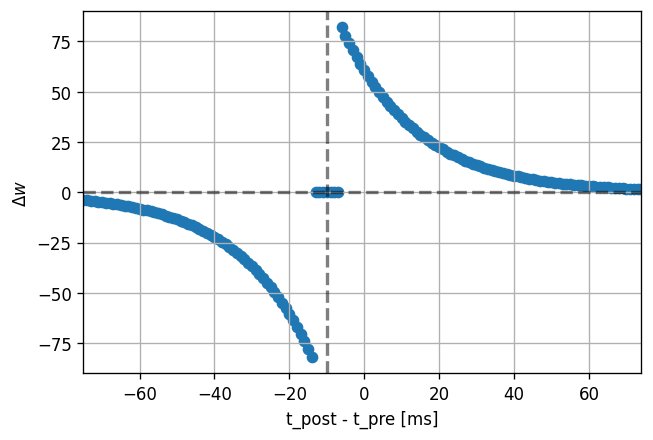

In [16]:
dt_vec, dw_vec, delay = stdp_window(neuron_model_name, synapse_model_name)
plot_stdp_window(dt_vec, dw_vec, delay)

Symmetric inhibitory STDP
--------------------

<!--
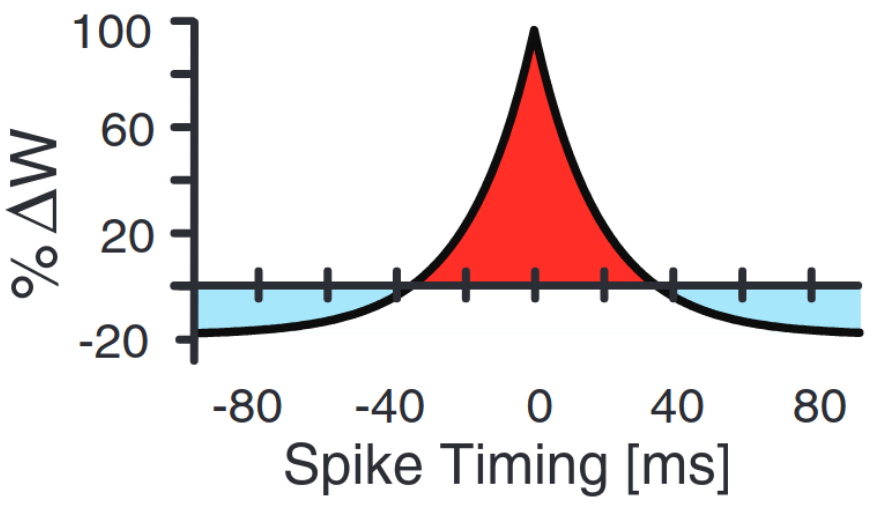
-->
<div>
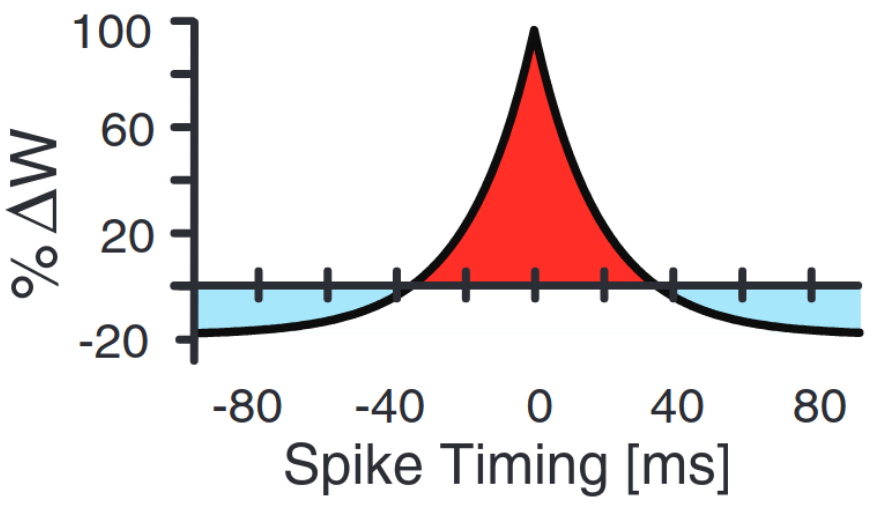
</div>

The symmetric STDP window in the figure can be observed experimentally and was used to achieve a self-organised balance between excitation and inhibition in recurrent networks [4]_.

In [17]:
nestml_stdp_vogels_model = """
synapse stdp_vogels:

  state:
    w real = 1.
  end

  parameters:
    d ms = 1 ms  @nest::delay   # !!! cannot have a variable called "delay"
    lambda real = .01
    tau_tr_pre ms = 20 ms
    tau_tr_post ms = 20 ms
    alpha real = 1
    mu_plus real = 1
    mu_minus real = 1
    Wmax real = 100.
    Wmin real = 0.
  end

  equations:
    kernel pre_trace_kernel = exp(-t / tau_tr_pre)
    inline pre_trace real = convolve(pre_trace_kernel, pre_spikes)

    # all-to-all trace of postsynaptic neuron
    kernel post_trace_kernel = exp(-t / tau_tr_post)
    inline post_trace real = convolve(post_trace_kernel, post_spikes)
  end

  input:
    pre_spikes nS <- spike
    post_spikes nS <- spike
  end

  output: spike

  postReceive:
    # potentiate synapse
    w += pre_trace + post_trace
  end

  preReceive:
    # depress synapse
    w -= .1
    w += pre_trace + post_trace

    # deliver spike to postsynaptic partner
    deliver_spike(w, d)
  end
end
"""

Save to a temporary file and make the model available to instantiate in NEST:

In [27]:
neuron_model_name, synapse_model_name = generate_code_for(nestml_stdp_vogels_model)

[1,GLOBAL, INFO]: List of files that will be processed:
[2,GLOBAL, INFO]: /home/charl/julich/nestml-fork-jit-third-factor/nestml/doc/tutorials/stdp_windows/models/iaf_psc_delta5.nestml
[3,GLOBAL, INFO]: /home/charl/julich/nestml-fork-jit-third-factor/nestml/doc/tutorials/stdp_windows/models/stdp_vogels5.nestml
[4,GLOBAL, INFO]: Start processing '/home/charl/julich/nestml-fork-jit-third-factor/nestml/doc/tutorials/stdp_windows/models/iaf_psc_delta5.nestml'!
ANTLR runtime and generated code versions disagree: 4.9.2!=4.7.1
ANTLR runtime and generated code versions disagree: 4.9.2!=4.7.1
[5,iaf_psc_delta5_nestml, INFO, [58:0;131:0]]: Start building symbol table!
[6,iaf_psc_delta5_nestml, WARNING, [67:4;67:22]]: Variable 'G' has the same name as a physical unit!
[7,iaf_psc_delta5_nestml, WARNING, [88:4;88:22]]: Variable 'h' has the same name as a physical unit!
[8,iaf_psc_delta5_nestml, WARNING, [69:70;69:70]]: Non-matching unit types at pA +/- pA buffer! Implicitly replaced by pA +/- 1.0 *

INFO:ode-toolbox: analysing input:
INFO:{
    "dynamics": [
        {
            "expression": "V_abs' = -V_abs / tau_m + (1.0 / 1.0 / 1.0) * 0 + (I_e + I_stim) / C_m",
            "initial_values": {
                "V_abs": "0"
            }
        },
        {
            "expression": "post_trace_kernel__for_stdp_vogels5_nestml__X__post_spikes__for_stdp_vogels5_nestml = exp(-t / tau_tr_post__for_stdp_vogels5_nestml)",
            "initial_values": {}
        }
    ],
    "options": {
        "output_timestep_symbol": "__h"
    },
    "parameters": {
        "C_m": "250",
        "E_L": "-70",
        "I_e": "0",
        "Theta": "-55 - E_L",
        "V_min": "-inf * 1",
        "V_reset": "-70 - E_L",
        "t_ref": "2",
        "tau_m": "10",
        "tau_syn": "2",
        "tau_tr_post__for_stdp_vogels5_nestml": "20",
        "with_refr_input": "false"
    }
}
INFO:Processing global options...
INFO:Processing input shapes...
INFO:
Processing shape V_abs with defining expressi

ANTLR runtime and generated code versions disagree: 4.9.2!=4.7.1
ANTLR runtime and generated code versions disagree: 4.9.2!=4.7.1
ANTLR runtime and generated code versions disagree: 4.9.2!=4.7.1
ANTLR runtime and generated code versions disagree: 4.9.2!=4.7.1
ANTLR runtime and generated code versions disagree: 4.9.2!=4.7.1
ANTLR runtime and generated code versions disagree: 4.9.2!=4.7.1
ANTLR runtime and generated code versions disagree: 4.9.2!=4.7.1
ANTLR runtime and generated code versions disagree: 4.9.2!=4.7.1
ANTLR runtime and generated code versions disagree: 4.9.2!=4.7.1
ANTLR runtime and generated code versions disagree: 4.9.2!=4.7.1
ANTLR runtime and generated code versions disagree: 4.9.2!=4.7.1
ANTLR runtime and generated code versions disagree: 4.9.2!=4.7.1
[31,iaf_psc_delta5_nestml__with_stdp_vogels5_nestml, INFO, [58:0;131:0]]: Start building symbol table!
[32,iaf_psc_delta5_nestml__with_stdp_vogels5_nestml, WARNING, [88:4;88:22]]: Variable 'h' has the same name as a phys

INFO:ode-toolbox: analysing input:
INFO:{
    "dynamics": [
        {
            "expression": "pre_trace_kernel__X__pre_spikes = exp(-t / tau_tr_pre)",
            "initial_values": {}
        }
    ],
    "options": {
        "output_timestep_symbol": "__h"
    },
    "parameters": {
        "Wmax": "1.000000E+02",
        "Wmin": "0.000000E+00",
        "alpha": "1",
        "d": "1",
        "lambda": "1.000000E-02",
        "mu_minus": "1",
        "mu_plus": "1",
        "tau_tr_pre": "20"
    }
}
INFO:Processing global options...
INFO:Processing input shapes...
INFO:
Processing shape pre_trace_kernel__X__pre_spikes with defining expression = "exp(-t/tau_tr_pre)"
INFO:
Processing shape pre_trace_kernel__X__pre_spikes with defining expression = "exp(-t/tau_tr_pre)"
INFO:Shape pre_trace_kernel__X__pre_spikes: reconstituting expression -pre_trace_kernel__X__pre_spikes/tau_tr_pre
INFO:Dependency analysis...
INFO:Generating propagators for the following symbols: pre_trace_kernel__X__

ANTLR runtime and generated code versions disagree: 4.9.2!=4.7.1
ANTLR runtime and generated code versions disagree: 4.9.2!=4.7.1
failure resolving symbol: post_spikes__for_stdp_vogels5_nestml
ANTLR runtime and generated code versions disagree: 4.9.2!=4.7.1
ANTLR runtime and generated code versions disagree: 4.9.2!=4.7.1
ANTLR runtime and generated code versions disagree: 4.9.2!=4.7.1
ANTLR runtime and generated code versions disagree: 4.9.2!=4.7.1
Analysing/transforming synapse stdp_vogels5_nestml__with_iaf_psc_delta5_nestml.
[33,stdp_vogels5_nestml__with_iaf_psc_delta5_nestml, INFO, [2:0;49:0]]: Starts processing of the model 'stdp_vogels5_nestml__with_iaf_psc_delta5_nestml'
ANTLR runtime and generated code versions disagree: 4.9.2!=4.7.1
ANTLR runtime and generated code versions disagree: 4.9.2!=4.7.1
[34,stdp_vogels5_nestml__with_iaf_psc_delta5_nestml, INFO, [2:0;49:0]]: The neuron 'stdp_vogels5_nestml__with_iaf_psc_delta5_nestml' will be analysed!
ANTLR runtime and generated code 

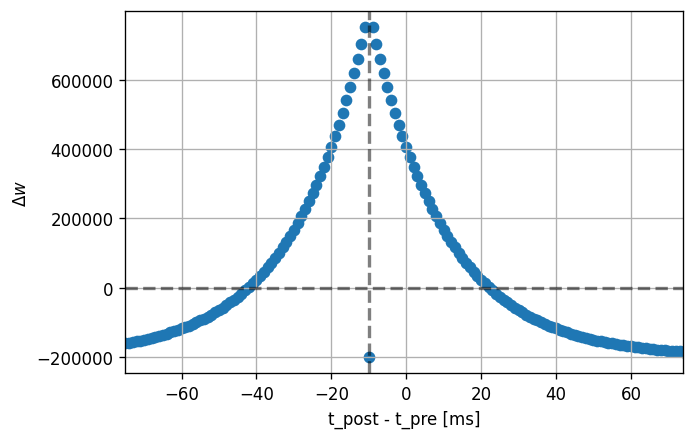

In [28]:
import matplotlib as mpl
mpl.rcParams['axes.formatter.useoffset'] = False
dt_vec, dw_vec, delay = stdp_window(neuron_model_name,
                                    synapse_model_name,
                                    synapse_parameters={"lambda": 1E-3})
plot_stdp_window(dt_vec, dw_vec, delay)

Further directions
---------------------
  
* **Bursting dependent rules**

  Neuronal bursting is when action potentials are fired at high frequency in groups, separated by periods of quiescence. Bursting can be considered a different communication signal from the normal firing of action potentials. Search for (or come up with) a burst-dependent learning rule, and implement it in NESTML.

  <p>&nbsp;</p>
  
* **Triplet relationships**

  So far, we have looked at the relative timing of two spikes, $\Delta t$ on the horizontal axis.

  Come up with a triplet spike protocol, that involves not just the time difference between two but between three spikes. Make a 3D plot of $\Delta w$ as a function of the timing parameters $\Delta t_1$ and $\Delta t_2$. What do you expect to see?

  <p>&nbsp;</p>

* **Multiphasic windows**
  
  Patch clamping is a common recording technique that uses a micropipette filled with a liquid that mimics the intracellular environment. When cesium ions (Cs<sup>+</sup>) are introduced into this solution, an extra potentiation window is seen for long pre-after-post delays. This thought to be caused by cesium blocking of potassium channels, which depolarises the postsynaptic neuron, and enhance and lengthen backpropagating action potentials in the apical dendrite [I]_.

  <!--
  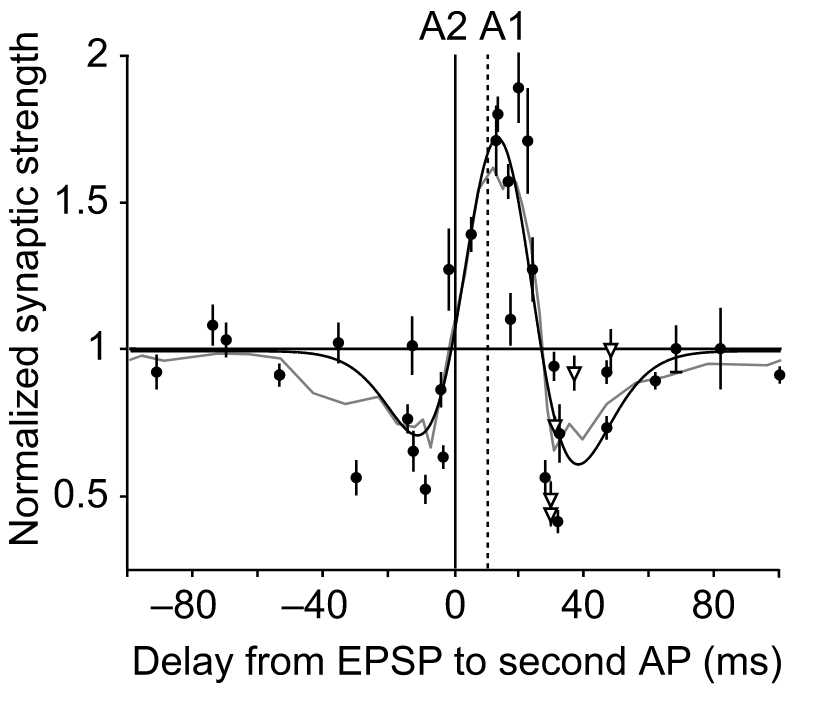
  -->
  <div>
  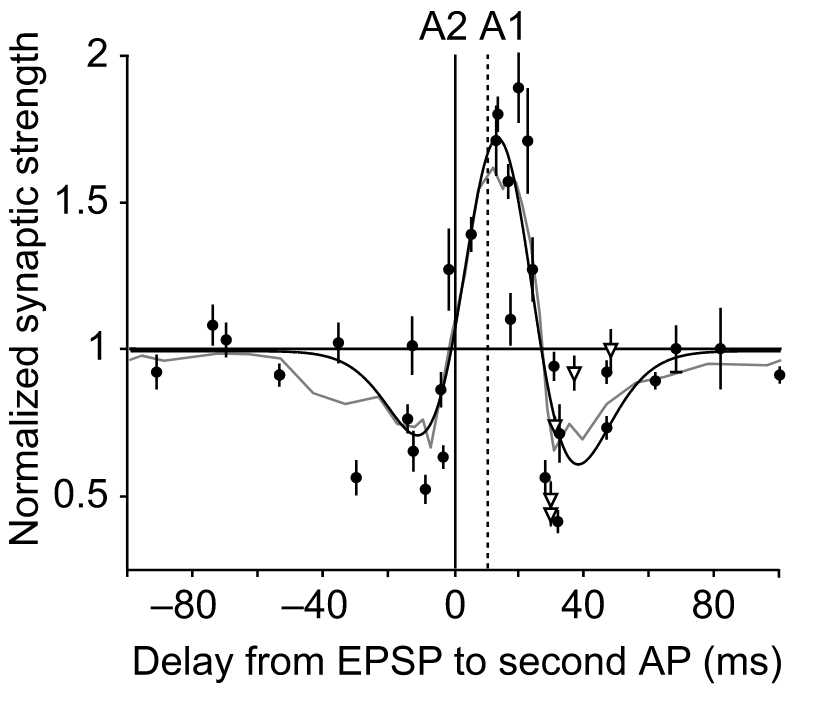
  </div>

  In the figure, the data is fit with a difference-of-gaussians curve (continuous black line). It could be easier to approach this using the existing exponentially decaying trace values, but add an additional trace with higher-order dynamics (where the exponentially decaying function has order 1).
  
  [I] Malleability of Spike-Timing-Dependent Plasticity at the CA3–CA1 Synapse
  Gayle M. Wittenberg, Samuel S.-H. Wang
  Journal of Neuroscience 14 June 2006, 26 (24) 6610-6617

References
----------

[1] Morrison A., Diesmann M., and Gerstner W. (2008) Phenomenological models of synaptic plasticity based on spike timing, Biol. Cybern. 98, 459–478 https://doi.org/10.1007/s00422-008-0233-1

[2] Front. Comput. Neurosci., 23 November 2010 Enabling functional neural circuit simulations with distributed computing of neuromodulated plasticity, Wiebke Potjans, Abigail Morrison and Markus Diesmann https://doi.org/10.3389/fncom.2010.00141 

[3] Rubin, Lee and Sompolinsky. Equilibrium Properties of Temporally Asymmetric Hebbian Plasticity. Physical Review Letters, 8 Jan 2001, Vol 86, No 2 http://doi.org/10.1103/PhysRevLett.86.364

[4] Vogels, Sprekeler, Zenke, Clopath and Gerstner (2011). Inhibitory Plasticity Balances Excitation and Inhibition in Sensory Pathways and Memory Networks. Science Vol 334 https://doi.org/10.1126/science.1211095 

Acknowledgements
----------------

The authors thank Younes Bouhadjar for his suggestions on use cases and valuable feedback.

This software was developed in part or in whole in the Human Brain Project, funded from the European Union’s Horizon 2020 Framework Programme for Research and Innovation under Specific Grant Agreements No. 720270 and No. 785907 (Human Brain Project SGA1 and SGA2).

License
-------

This notebook (and associated files) is free software: you can redistribute it and/or modify it under the terms of the GNU General Public License as published by the Free Software Foundation, either version 2 of the License, or (at your option) any later version.

This notebook (and associated files) is distributed in the hope that it will be useful, but WITHOUT ANY WARRANTY; without even the implied warranty of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the GNU General Public License for more details.